## Capstone project: The Battle of Neighborhoods - Week 1 

## Table of contents
1. Introduction: Business Problem
2. Data
3. Methodology
4. Results and Discussion
5. Conclusion

## Introduction: Business Problem

The objective of this Capstone project is to analyze and find best possible location in New York City to open an Indian cuisine restaurant with western twist. 
New York is the largest city in US with a long history of international immigrants that has population of diverse culture, cuisine and magnificent people. New York is home to an array of outstanding Indian restaurants that serve cuisine akin to that found in Indian households or India itself, including amazing regional specialties, takeout tikka masala, and handheld snacks.As with any new business, it is important to analyze the location, neighborhood, and other factors that would lead the new Indian restaurant to great success and profit. 


## Data
To solve the business problem, following data are required:
- data on New York City neighborhoods
- boroughs to include boundaries, latitude, longitude, restaurants 
- restaurant ratings and tips

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json

All data related to locations and quality of Indian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

* Foursquare API:
This project would use Four-square API as its prime data gathering source as it has a database of millions of places, especially their places API which provides the ability to perform location search, location sharing and details about a business.

* Work Flow:
Using credentials of Foursquare API features of near-by places of the neighborhoods would be mined. Due to http request limitations the number of places per neighborhood parameter would reasonably be set to 100 and the radius parameter would be set to 500.

* Clustering Approach:
 k-means clustering algorithm

 Libraries Which are Used to Develope the Project:
- Pandas: For creating and manipulating dataframes.

- Folium: Python visualization library would be used to visualize the neighborhoods cluster distribution of using interactive leaflet map.

- Scikit Learn: For importing k-means clustering.

- JSON: Library to handle JSON files.

- XML: To separate data from presentation and XML stores data in plain text format.

- Geocoder: To retrieve Location Data.

- Beautiful Soup and Requests: To scrap and library to handle http requests.

- Matplotlib: Python Plotting Module.

## Import all required libraries 

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!pip install geopy
import json # library to handle JSON files


#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 112kB 18.2MB/s eta 0:00:01
Libraries imported.


## NY Data

In [4]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [6]:
neighborhoods_data = newyork_data['features']

## Foursquare credentials

In [8]:
# Define Foursquare Credentials and Version

CLIENT_ID = '0UTFN52XFCN3DPCBDYE5MTWRUCAFGTA5BKV02FAN0ORW5NGP' # Foursquare Client id
CLIENT_SECRET = 'O4RJNR0RFKAX3EN2GY3EZDSHFX2KU2RGQT51I23GQWCNBEFY' # Foursquare Client secret
VERSION = '20180605' # Foursquare API version

## Define the functions 

In [9]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

## Our initial NYC data

In [10]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
ny_data.shape


(306, 4)

There are total of 306 different Neighborhoods in New York.

## Initial Data Analysis

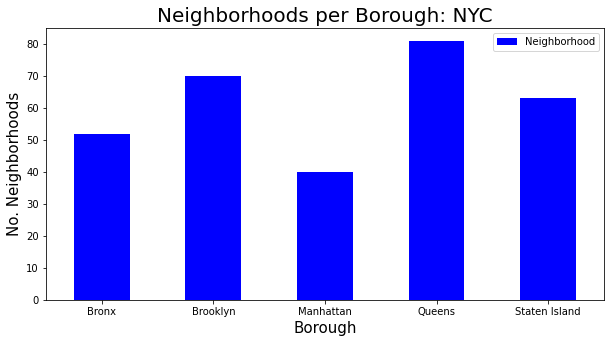

In [13]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

## Further in depth analysis to identify how many Indian restaurants are there in each neighborhood and borough followed by graphing the results.

In [14]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(ny_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    print(row)
    for resturant_detail in indian_restaurants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Indian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Indian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Indian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Indian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Indian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Indian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Indian Restaurants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Indian Restaurants in Norwood, Bronx:0
['Bronx', '

In [15]:
# Save the information to a .csv file due to limited calls on FourSquare
indian_rest_ny.to_csv('indian_rest_ny_tocsv1.csv')

In [16]:
indian_ny = pd.read_csv('indian_rest_ny_tocsv1.csv')
indian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
34,Manhattan,Civic Center,575dea4c498e2739e43a27e2,Aahar Indian Cuisine
35,Manhattan,Civic Center,50b02338e4b047828b2277c1,Benares
36,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant
37,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine
38,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux


In [17]:
indian_rest_ny.shape

(39, 4)

We got 39 Indian Restaurants across the New York City.

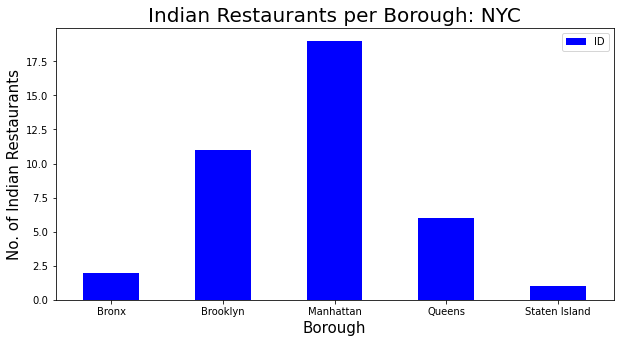

In [18]:
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

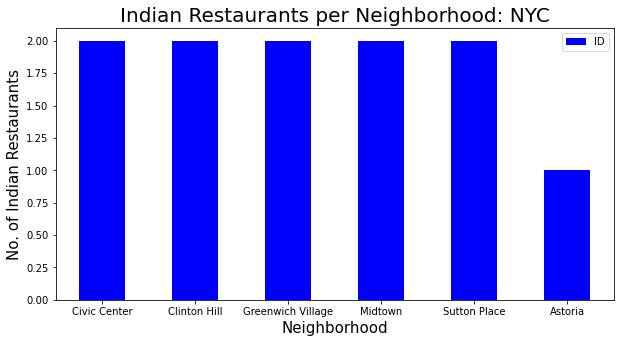

In [19]:
NOofNeigh = 6 # top number for graphing all the same past 6
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [20]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Midtown']

,Borough,Neighborhood,ID,Name
18,Manhattan,Midtown,49d91c12f964a520015e1fe3,The Kati Roll Company
19,Manhattan,Midtown,5953e40462420b044e8989f4,deep Indian Kitchen


In [21]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Civic Center']

,Borough,Neighborhood,ID,Name
34,Manhattan,Civic Center,575dea4c498e2739e43a27e2,Aahar Indian Cuisine
35,Manhattan,Civic Center,50b02338e4b047828b2277c1,Benares


In [22]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Clinton Hill']

,Borough,Neighborhood,ID,Name
8,Brooklyn,Clinton Hill,568d3902498e619efcbc3f58,Spice & Grill
9,Brooklyn,Clinton Hill,4ace7c86f964a520d3d020e3,Kinara's


In [23]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Greenwich Village']

,Borough,Neighborhood,ID,Name
21,Manhattan,Greenwich Village,56c931b2cd10407d3ecbefda,Ananda
22,Manhattan,Greenwich Village,4593ed04f964a52050401fe3,The Kati Roll Company


In [24]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Jamaica Hills']

,Borough,Neighborhood,ID,Name
36,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant


In [25]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Sutton Place']

,Borough,Neighborhood,ID,Name
37,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine
38,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux


Manhattan has the highest number of Indian Restaurants.
Now we will get the ranking of each restaurant for further analysis.

In [26]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
indian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '607512f6c152517b3b718d50'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': 'entrance', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
34,Manhattan,Civic Center,575dea4c498e2739e43a27e2,Aahar Indian Cuisine,53,8.2,20
35,Manhattan,Civic Center,50b02338e4b047828b2277c1,Benares,98,7.4,44
36,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant,10,7.0,6
37,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine,155,8.3,58
38,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,186,8.2,83


In [30]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv') # save data to a .csv file

In [31]:
indian_rest_stats_ny.shape

(39, 7)

In [32]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       39 non-null     object 
 1   Neighborhood  39 non-null     object 
 2   ID            39 non-null     object 
 3   Name          39 non-null     object 
 4   Likes         39 non-null     object 
 5   Rating        39 non-null     float64
 6   Tips          39 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.3+ KB


In [33]:
indian_rest_stats_ny['Likes'] = indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips'] = indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       39 non-null     object 
 1   Neighborhood  39 non-null     object 
 2   ID            39 non-null     object 
 3   Name          39 non-null     object 
 4   Likes         39 non-null     float64
 5   Rating        39 non-null     float64
 6   Tips          39 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.3+ KB


In [34]:
indian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,39.000000,39.000000,39.000000
mean,96.512821,7.776923,32.102564
std,169.809626,0.874932,49.338143
min,3.000000,5.600000,2.000000
25%,16.000000,7.500000,7.500000
50%,38.000000,7.900000,17.000000
75%,88.500000,8.300000,28.500000
max,834.000000,9.000000,256.000000


In [35]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.5
Tips                                 256
Name: 18, dtype: object

In [36]:
# Resturant with maximum Ratings
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                602
Rating                                 9
Tips                                 151
Name: 23, dtype: object

In [37]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.5
Tips                                 256
Name: 18, dtype: object

# visualize and identify neighborhood with the maximum average rating of restaurants

In [38]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
27,Tribeca,9.00
24,Prospect Lefferts Gardens,8.80
22,Noho,8.80
6,Chelsea,8.80
13,Greenwich Village,8.65
10,Fort Greene,8.60
31,West Village,8.50
20,Midtown,8.40
23,North Side,8.30
26,Sutton Place,8.25


 Above are the top neighborhoods with the highest average ratings of Indian restaurants.

In [39]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
4,Staten Island,8.200000
2,Manhattan,8.168421
3,Queens,7.416667
1,Brooklyn,7.409091
0,Bronx,6.950000


 These are the average ratings of Indian Restaurants for each Borough

## Visualization of the results

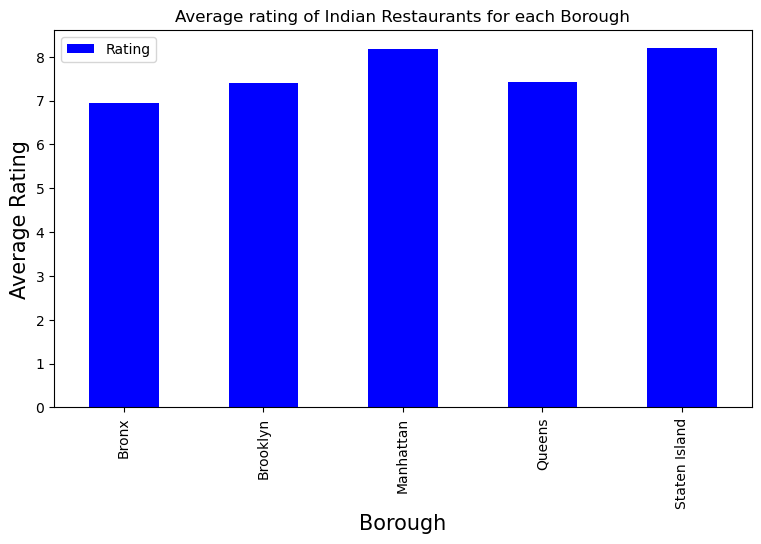

In [40]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Indian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

We will consider all the neighborhoods with average rating >= 8.0 to visualize on a map

In [41]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,8.20
2,Bayside,8.00
3,Boerum Hill,8.10
6,Chelsea,8.80
10,Fort Greene,8.60
11,Gowanus,8.00
13,Greenwich Village,8.65
20,Midtown,8.40
21,New Dorp,8.20
22,Noho,8.80



We will join this Dataset to original New York data to get longitude and latitude

In [42]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.20
1,Queens,Bayside,40.766041,-73.774274,8.00
2,Brooklyn,Boerum Hill,40.685683,-73.983748,8.10
3,Manhattan,Chelsea,40.744035,-74.003116,8.80
4,Staten Island,Chelsea,40.594726,-74.189560,8.80
5,Brooklyn,Fort Greene,40.688527,-73.972906,8.60
6,Brooklyn,Gowanus,40.673931,-73.994441,8.00
7,Manhattan,Greenwich Village,40.726933,-73.999914,8.65
8,Manhattan,Midtown,40.754691,-73.981669,8.40
9,Staten Island,New Dorp,40.572572,-74.116479,8.20


In [47]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
ny_map

In [45]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

# Results/Conclusion

Manhattan and Brooklyn have the best rated Indian restaurants.Based on the above information, I would state that Manhattan and Brooklyn are the best locations for Indian cuisine in NYC. To have the best shot of success, I would open a Indian restaurant in Manhattan. Manhattan has multiple neighborhoods with average ratings exceeding 8.0. Midtown in Manhattan has about 834 likes which is the highest among other neighborhood.
